<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 79 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Unnamed: 0                                           1781 non-null   int64  
 1   Ticker Symbol                                        1781 non-null   object 
 2   Period Ending                                        1781 non-null   object 
 3   Accounts Payable                                     1781 non-null   float64
 4   Accounts Receivable                                  1781 non-null   float64
 5   Add'l income/expense items                           1781 non-null   float64
 6   After Tax ROE                                        1781 non-null   float64
 7   Capital Expenditures                                 1781 non-null   float64
 8   Capital Surplus                                      1781 non-null  

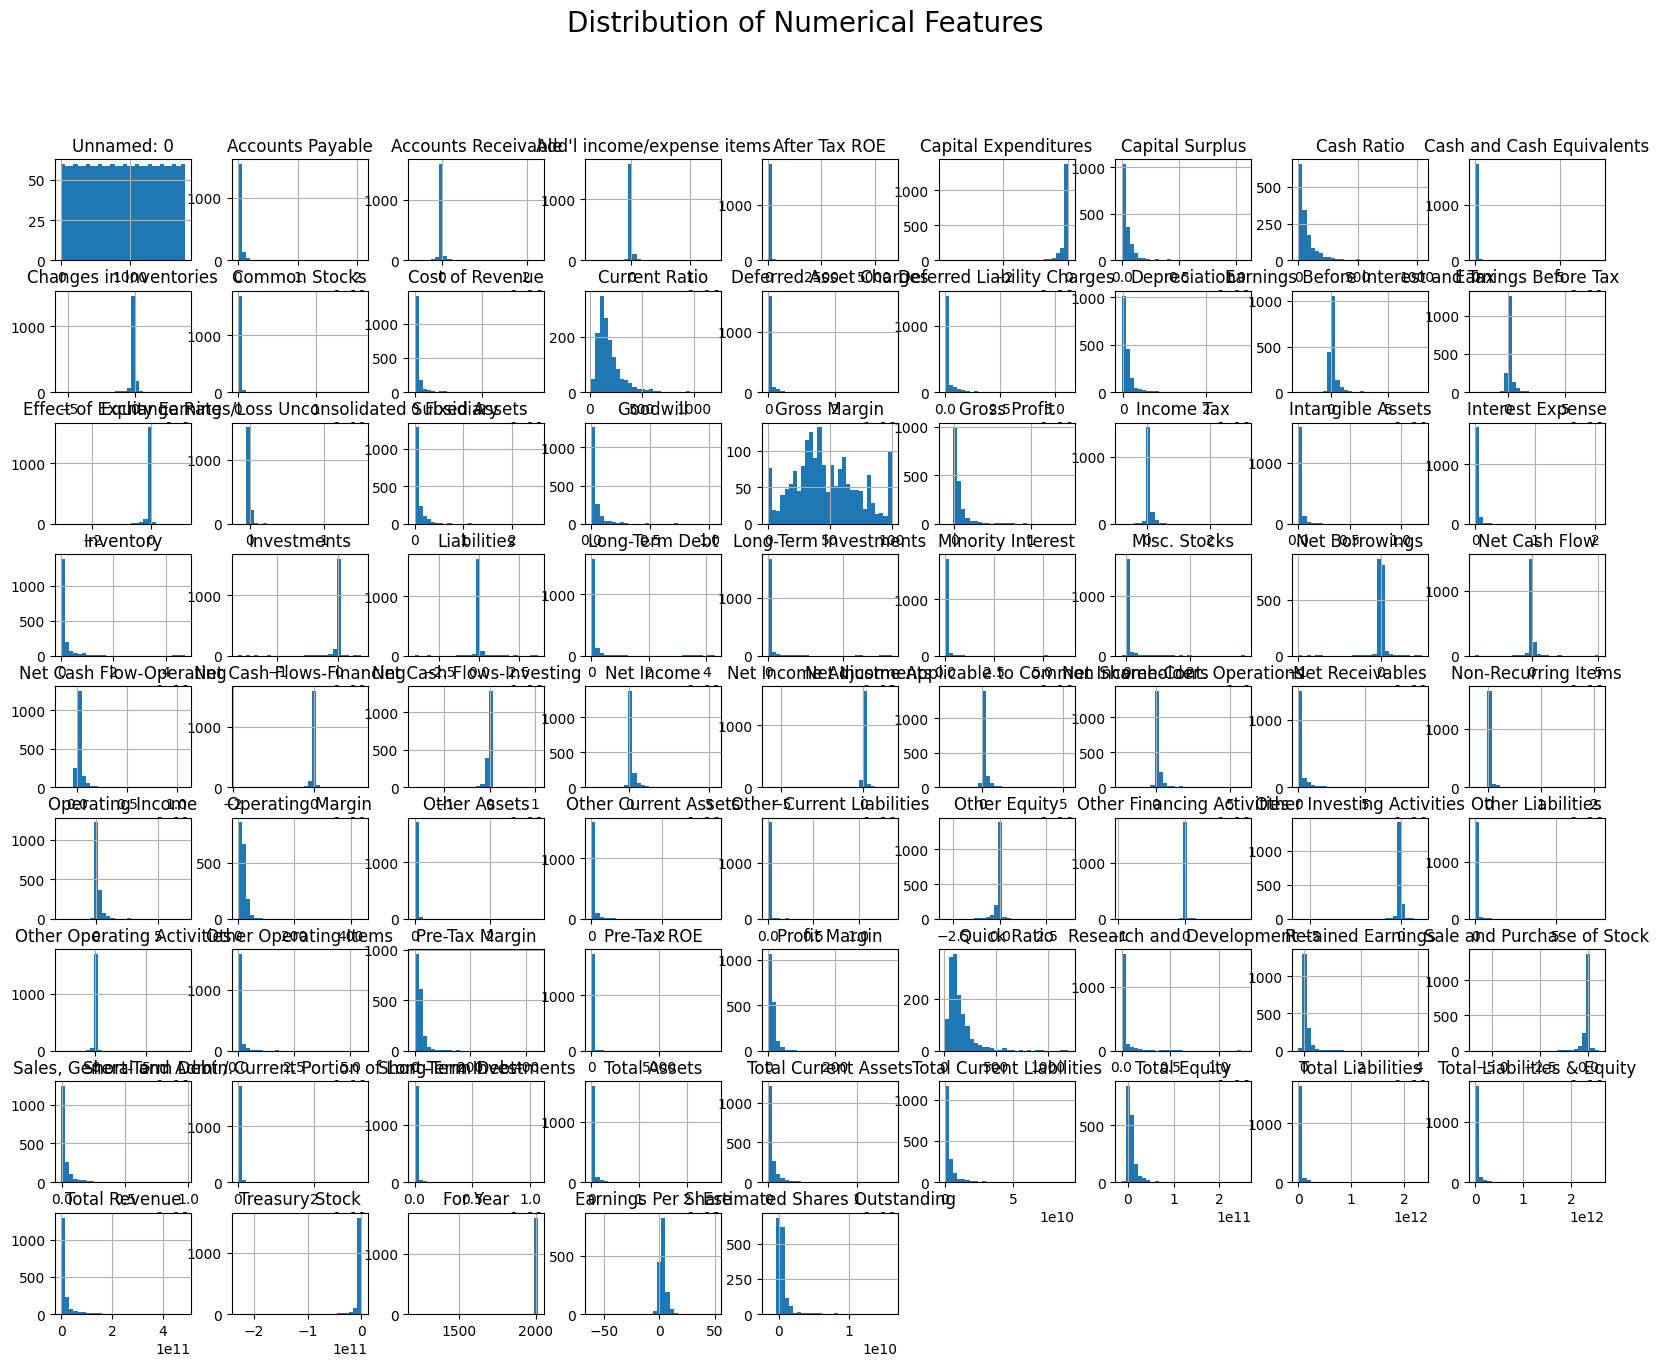

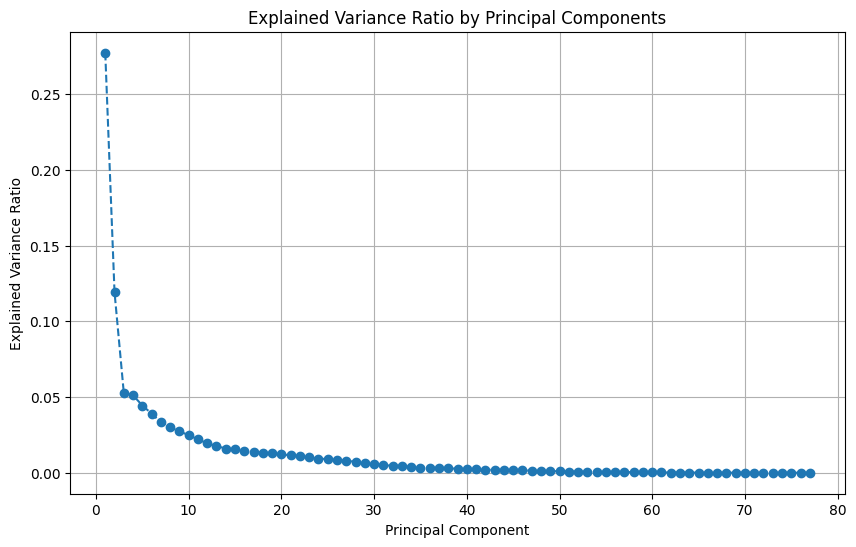

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.653818  0.500317  0.547054 -1.470733 -0.221119 -1.716416 -1.512705   
1 -1.021756  0.472876  0.683817 -0.848705 -0.142349 -2.572861 -1.970029   
2  1.358999 -0.964209  0.467347 -0.948418 -0.117291 -0.382341 -0.988341   
3  2.259026 -1.288878  0.045656 -0.487607 -0.289988 -0.043304 -0.399162   
4 -1.839953  0.114214 -0.696572 -1.225184 -0.230461  0.193448 -0.438280   

        PC8       PC9      PC10  ...      PC68      PC69      PC70      PC71  \
0 -0.033093 -0.284251 -0.192979  ...  0.134441 -0.208752 -0.033477 -0.074705   
1  0.269389 -0.344730 -0.034843  ...  0.196677 -0.244355 -0.050783 -0.065395   
2  0.296476  0.318803  0.439353  ...  0.018562  0.036989  0.014148 -0.011817   
3  0.748577  1.216869  0.186429  ...  0.013553  0.001848  0.010988 -0.004029   
4 -0.066279  0.424228 -0.193180  ...  0.002454  0.002630 -0.001015 -0.002806   

       PC72      PC73      PC74      PC75      PC76          PC77  


In [4]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

df = pd.read_csv('/kaggle/input/nyse/fundamentals.csv')

# Display basic information about the dataset
print(df.info())
print(df.describe())

#Visualize Data Distribution and Relationships
# -----------------------------------------------------
# Histograms for numerical columns
df.hist(bins=30, figsize=(20, 15))
plt.suptitle("Distribution of Numerical Features", fontsize=20)
plt.show()

# Assuming you have a dataframe 'df'
# Separate numeric and categorical columns
numeric_columns = df.select_dtypes(include=['number']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Step 1: Impute missing values
# Impute numeric columns with the mean
numeric_imputer = SimpleImputer(strategy='mean')
df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

# Impute categorical columns with the most frequent value (mode)
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

# Step 2: Standardize the numeric data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numeric_columns])  # Scale only numeric columns

# Step 3: Apply PCA
pca = PCA()
pca.fit(df_scaled)

# Step 4: Visualize the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Optional: You can also reduce the dimensions using PCA, for example, to 2 components:
df_pca = pca.transform(df_scaled)  # Transform the data into principal components
df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])])  # Convert to DataFrame

# You can check the new DataFrame 'df_pca' with reduced dimensions
print(df_pca.head())


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming df_pca is the result of PCA and your target variable is in `target_column`
# Example: df_pca contains the PCA components, and 'target' is the column to predict.

# Separate features and target
X = df_pca.values  # Assuming df_pca contains the PCA-transformed features
y = df['Earnings Per Share'].values  # Replace 'target_column' with the actual name of your target column

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features (important for DNN performance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape to (n_samples, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Reshape to (n_samples, 1)

# Define the model architecture (3 hidden layers)
class DNNModel(nn.Module):
    def __init__(self, input_dim):
        super(DNNModel, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 128)  # First hidden layer (128 neurons)
        self.hidden2 = nn.Linear(128, 64)         # Second hidden layer (64 neurons)
        self.hidden3 = nn.Linear(64, 32)          # Third hidden layer (32 neurons)
        self.output = nn.Linear(32, 1)            # Output layer (1 neuron for regression)
        
        self.relu = nn.ReLU()  # ReLU activation function
        self.dropout = nn.Dropout(0.2)  # Dropout for regularization
        
    def forward(self, x):
        x = self.relu(self.hidden1(x))  # Apply hidden layer 1 + ReLU
        x = self.dropout(x)             # Apply dropout
        x = self.relu(self.hidden2(x))  # Apply hidden layer 2 + ReLU
        x = self.dropout(x)             # Apply dropout
        x = self.relu(self.hidden3(x))  # Apply hidden layer 3 + ReLU
        x = self.output(x)              # Output layer (no activation function here)
        return x

# Instantiate the model
input_dim = X_train.shape[1]  # The number of PCA components/features
model = DNNModel(input_dim)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()  # Clear the gradients
    loss.backward()        # Compute the gradients
    optimizer.step()       # Update the weights
    
    # Print the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for inference
    y_pred = model(X_test_tensor)

# You can now compare the predicted values (y_pred) with the true values (y_test_tensor)
# You may also calculate the performance metrics such as RMSE, R^2, etc.


Epoch [10/100], Loss: 26.7338
Epoch [20/100], Loss: 22.4149
Epoch [30/100], Loss: 15.7934
Epoch [40/100], Loss: 11.3532
Epoch [50/100], Loss: 8.0018
Epoch [60/100], Loss: 6.1282
Epoch [70/100], Loss: 5.2463
Epoch [80/100], Loss: 4.9184
Epoch [90/100], Loss: 4.7728
Epoch [100/100], Loss: 4.3856


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df_pca.values  # Assuming df_pca contains the PCA-transformed features
y = df['Earnings Per Share'].values  # Replace 'target_column' with the actual name of your target column

# Train/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary test data into validation and test sets (80%/20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 of 0.2 = 0.05

# Standardize the input features (important for DNN performance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape to (n_samples, 1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)  # Reshape to (n_samples, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Reshape to (n_samples, 1)

# Define the model architecture (3 hidden layers)
class DNNModel(nn.Module):
    def __init__(self, input_dim):
        super(DNNModel, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 128)  # First hidden layer (128 neurons)
        self.hidden2 = nn.Linear(128, 64)         # Second hidden layer (64 neurons)
        self.hidden3 = nn.Linear(64, 32)          # Third hidden layer (32 neurons)
        self.output = nn.Linear(32, 1)            # Output layer (1 neuron for regression)
        
        self.relu = nn.ReLU()  # ReLU activation function
        self.dropout = nn.Dropout(0.2)  # Dropout for regularization
        
    def forward(self, x):
        x = self.relu(self.hidden1(x))  # Apply hidden layer 1 + ReLU
        x = self.dropout(x)             # Apply dropout
        x = self.relu(self.hidden2(x))  # Apply hidden layer 2 + ReLU
        x = self.dropout(x)             # Apply dropout
        x = self.relu(self.hidden3(x))  # Apply hidden layer 3 + ReLU
        x = self.output(x)              # Output layer (no activation function here)
        return x

# 5. Hyperparameter Tuning Loop
learning_rates = [0.001, 0.01, 0.1]
optimizers = ['SGD', 'Adam', 'RMSprop']
epochs_list = [50, 100, 200]

best_model = None
best_params = None
best_val_loss = float('inf')

# Loop through all combinations of hyperparameters
for lr in learning_rates:
    for optimizer_name in optimizers:
        for epochs in epochs_list:
            
            # Initialize the model
            model = DNNModel(input_dim=X_train.shape[1])  # Use DNNModel instead of StockPricePredictor
            
            # Select optimizer
            if optimizer_name == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=lr)
            elif optimizer_name == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)
            elif optimizer_name == 'RMSprop':
                optimizer = optim.RMSprop(model.parameters(), lr=lr)
            
            # Training the model
            for epoch in range(epochs):
                model.train()
                
                # Forward propagation
                y_pred = model(X_train_tensor)
                
                # Loss function
                loss_fn = nn.MSELoss()
                loss = loss_fn(y_pred, y_train_tensor)
                
                # Backward propagation and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Validation loss after training
            model.eval()
            with torch.no_grad():
                val_pred = model(X_val_tensor)
                val_loss = loss_fn(val_pred, y_val_tensor)
            
            # Save the best model based on validation loss
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_model = model
                best_params = {'learning_rate': lr, 'optimizer': optimizer_name, 'epochs': epochs}

            print(f"LR: {lr}, Optimizer: {optimizer_name}, Epochs: {epochs}, Val Loss: {val_loss.item():.4f}")

# 6. Test the Best Model
best_model.eval()
with torch.no_grad():
    y_test_pred = best_model(X_test_tensor)
    test_loss = loss_fn(y_test_pred, y_test_tensor)
    
print(f'Test Loss for Best Model: {test_loss.item():.4f}')
print(f'Best Hyperparameters: {best_params}')

# Optionally, you can evaluate the model's performance using other metrics (e.g., RMSE, MAE)
y_test_pred_np = y_test_pred.numpy()
y_test_np = y_test_tensor.numpy()

mae = mean_absolute_error(y_test_np, y_test_pred_np)
rmse = math.sqrt(mean_squared_error(y_test_np, y_test_pred_np))

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')


LR: 0.001, Optimizer: SGD, Epochs: 50, Val Loss: 33.8488
LR: 0.001, Optimizer: SGD, Epochs: 100, Val Loss: 29.7780
LR: 0.001, Optimizer: SGD, Epochs: 200, Val Loss: 24.7675
LR: 0.001, Optimizer: Adam, Epochs: 50, Val Loss: 12.9167
LR: 0.001, Optimizer: Adam, Epochs: 100, Val Loss: 7.3442
LR: 0.001, Optimizer: Adam, Epochs: 200, Val Loss: 2.1664
LR: 0.001, Optimizer: RMSprop, Epochs: 50, Val Loss: 2.8957
LR: 0.001, Optimizer: RMSprop, Epochs: 100, Val Loss: 2.1481
LR: 0.001, Optimizer: RMSprop, Epochs: 200, Val Loss: 1.6985
LR: 0.01, Optimizer: SGD, Epochs: 50, Val Loss: 8.9728
LR: 0.01, Optimizer: SGD, Epochs: 100, Val Loss: 6.2360
LR: 0.01, Optimizer: SGD, Epochs: 200, Val Loss: 1.6429
LR: 0.01, Optimizer: Adam, Epochs: 50, Val Loss: 1.9180
LR: 0.01, Optimizer: Adam, Epochs: 100, Val Loss: 1.3098
LR: 0.01, Optimizer: Adam, Epochs: 200, Val Loss: 1.4249
LR: 0.01, Optimizer: RMSprop, Epochs: 50, Val Loss: 9.4286
LR: 0.01, Optimizer: RMSprop, Epochs: 100, Val Loss: 7.5960
LR: 0.01, Optim

Epoch 1/200, Training Loss: 29.0138, Validation Loss: 33.3687
Epoch 2/200, Training Loss: 27.3489, Validation Loss: 31.5083
Epoch 3/200, Training Loss: 25.2925, Validation Loss: 28.9897
Epoch 4/200, Training Loss: 22.7081, Validation Loss: 25.8352
Epoch 5/200, Training Loss: 19.6634, Validation Loss: 22.2350
Epoch 6/200, Training Loss: 16.3715, Validation Loss: 18.5987
Epoch 7/200, Training Loss: 13.2377, Validation Loss: 15.6292
Epoch 8/200, Training Loss: 10.8775, Validation Loss: 14.0905
Epoch 9/200, Training Loss: 9.7604, Validation Loss: 13.8604
Epoch 10/200, Training Loss: 9.3397, Validation Loss: 13.6189
Epoch 11/200, Training Loss: 8.5616, Validation Loss: 12.7340
Epoch 12/200, Training Loss: 7.2666, Validation Loss: 11.4489
Epoch 13/200, Training Loss: 5.9149, Validation Loss: 10.2681
Epoch 14/200, Training Loss: 4.9359, Validation Loss: 9.5103
Epoch 15/200, Training Loss: 4.4748, Validation Loss: 9.1576
Epoch 16/200, Training Loss: 4.3824, Validation Loss: 9.0127
Epoch 17/200

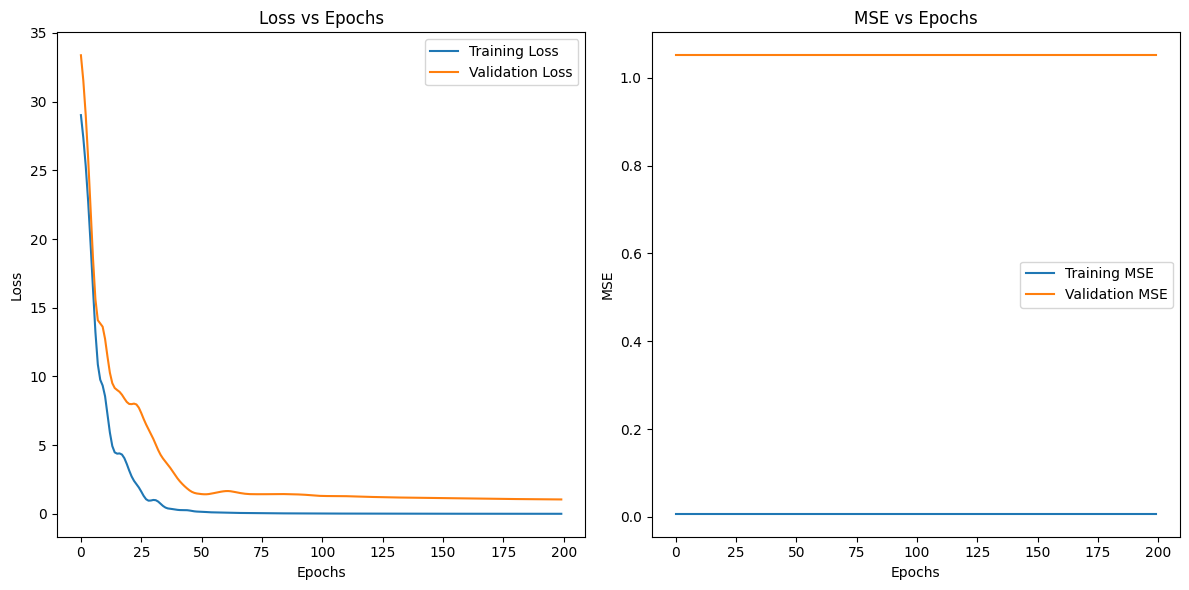

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn

class StockPricePredictor(nn.Module):
    def __init__(self, input_dim):
        super(StockPricePredictor, self).__init__()
        # Define a simple feedforward neural network
        self.fc1 = nn.Linear(input_dim, 64)  # First hidden layer with 64 units
        self.fc2 = nn.Linear(64, 32)         # Second hidden layer with 32 units
        self.fc3 = nn.Linear(32, 1)          # Output layer with 1 unit (since we're predicting stock price)
        self.relu = nn.ReLU()                # Activation function

    def forward(self, x):
        # Forward pass through the network
        x = self.relu(self.fc1(x))   # Apply first layer + ReLU activation
        x = self.relu(self.fc2(x))   # Apply second layer + ReLU activation
        x = self.fc3(x)              # Apply output layer
        return x

# 5. Hyperparameter Tuning Loop (use fixed hyperparameters for this example)
learning_rate = 0.01
optimizer_name = 'Adam'
epochs = 200

# Initialize the model (adjust input_dim to your dataset)
model = StockPricePredictor(input_dim=X_train.shape[1])

# Select optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Loss function
loss_fn = nn.MSELoss()

# 6. Training the model and recording losses
train_losses = []
val_losses = []

# Assuming X_train_tensor, y_train_tensor, X_val_tensor, and y_val_tensor are defined
# Make sure X_train_tensor and y_train_tensor are tensors, like:
# X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

for epoch in range(epochs):
    model.train()
    
    # Forward propagation
    y_train_pred = model(X_train_tensor)
    
    # Compute training loss
    train_loss = loss_fn(y_train_pred, y_train_tensor)
    
    # Backward propagation and optimization
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # Record the training loss
    train_losses.append(train_loss.item())
    
    # Validation loss
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val_tensor)
        val_loss = loss_fn(y_val_pred, y_val_tensor)
    
    # Record the validation loss
    val_losses.append(val_loss.item())
    
    # Print progress for every epoch
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

# 7. Plotting the loss curves
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# 8. Plotting MSE (Mean Squared Error) over epochs for both training and validation
train_mse = [mean_squared_error(y_train_tensor.numpy(), model(X_train_tensor).detach().numpy()) for _ in range(epochs)]
val_mse = [mean_squared_error(y_val_tensor.numpy(), model(X_val_tensor).detach().numpy()) for _ in range(epochs)]

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_mse, label='Training MSE')
plt.plot(range(epochs), val_mse, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('MSE vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/200, Training Loss: 31.9292, Validation Loss: 36.1859
Epoch 2/200, Training Loss: 29.5961, Validation Loss: 35.8349
Epoch 3/200, Training Loss: 26.7987, Validation Loss: 35.1816
Epoch 4/200, Training Loss: 22.9504, Validation Loss: 33.5420
Epoch 5/200, Training Loss: 19.1084, Validation Loss: 30.2355
Epoch 6/200, Training Loss: 15.2793, Validation Loss: 25.3584
Epoch 7/200, Training Loss: 12.8381, Validation Loss: 19.8021
Epoch 8/200, Training Loss: 11.5982, Validation Loss: 16.2481
Epoch 9/200, Training Loss: 11.2344, Validation Loss: 14.4202
Epoch 10/200, Training Loss: 9.8178, Validation Loss: 13.0725
Epoch 11/200, Training Loss: 8.6247, Validation Loss: 11.9851
Epoch 12/200, Training Loss: 8.3927, Validation Loss: 11.3398
Epoch 13/200, Training Loss: 7.5654, Validation Loss: 11.4274
Epoch 14/200, Training Loss: 6.8361, Validation Loss: 12.1242
Epoch 15/200, Training Loss: 6.5177, Validation Loss: 12.7748
Epoch 16/200, Training Loss: 5.7324, Validation Loss: 13.2671
Epoch 17

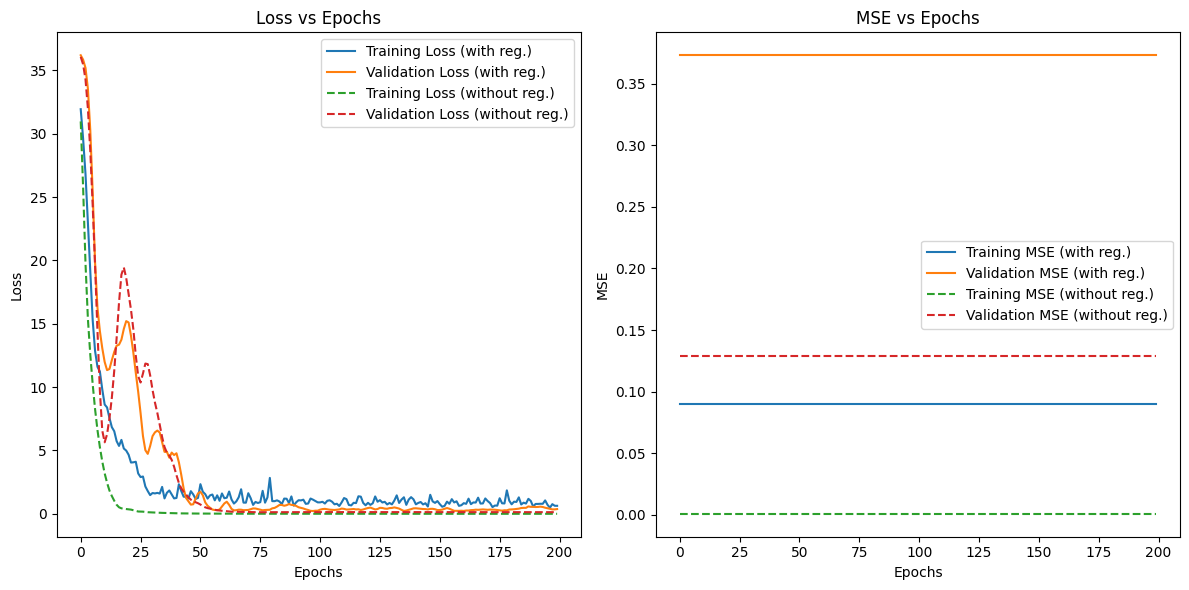

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 4. Define the model architecture with Dropout and Batch Normalization
class StockPricePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1, dropout_prob=0.3):
        super(StockPricePredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Batch Normalization
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.bn4 = nn.BatchNorm1d(hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))  # Batch Normalization + ReLU
        x = self.dropout(x)  # Dropout
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x

# 5. Hyperparameter Tuning Loop (for this example, we use fixed hyperparameters for simplicity)
learning_rate = 0.01
epochs = 200
dropout_prob = 0.3  # Dropout probability
weight_decay = 0.001  # L2 Regularization (weight decay)

# 6. Define a function for training the model
def train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, optimizer, loss_fn, epochs):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        
        # Forward propagation
        y_train_pred = model(X_train_tensor)
        
        # Compute training loss
        train_loss = loss_fn(y_train_pred, y_train_tensor)
        
        # Backward propagation and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # Record the training loss
        train_losses.append(train_loss.item())
        
        # Validation loss
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)
            val_loss = loss_fn(y_val_pred, y_val_tensor)
        
        # Record the validation loss
        val_losses.append(val_loss.item())
        
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")
    
    return train_losses, val_losses

# 7. Initialize the models and optimizers
# Model with Dropout and L2 Regularization (Weight Decay)
model_with_reg = StockPricePredictor(input_dim=X_train.shape[1])
optimizer_with_reg = optim.Adam(model_with_reg.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()

# Model without Dropout and L2 Regularization (Baseline)
model_without_reg = StockPricePredictor(input_dim=X_train.shape[1], dropout_prob=0.0)
optimizer_without_reg = optim.Adam(model_without_reg.parameters(), lr=learning_rate)

# Train the model with regularization (dropout + L2 regularization)
train_losses_with_reg, val_losses_with_reg = train_model(model_with_reg, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, optimizer_with_reg, loss_fn, epochs)

# Train the model without regularization (baseline)
train_losses_without_reg, val_losses_without_reg = train_model(model_without_reg, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, optimizer_without_reg, loss_fn, epochs)

# 8. Plotting the loss curves for comparison
plt.figure(figsize=(12, 6))

# Plot training and validation loss for models with and without regularization
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses_with_reg, label='Training Loss (with reg.)')
plt.plot(range(epochs), val_losses_with_reg, label='Validation Loss (with reg.)')
plt.plot(range(epochs), train_losses_without_reg, label='Training Loss (without reg.)', linestyle='dashed')
plt.plot(range(epochs), val_losses_without_reg, label='Validation Loss (without reg.)', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Plot MSE (Mean Squared Error) over epochs for both training and validation
train_mse_with_reg = [mean_squared_error(y_train_tensor.numpy(), model_with_reg(X_train_tensor).detach().numpy()) for _ in range(epochs)]
val_mse_with_reg = [mean_squared_error(y_val_tensor.numpy(), model_with_reg(X_val_tensor).detach().numpy()) for _ in range(epochs)]
train_mse_without_reg = [mean_squared_error(y_train_tensor.numpy(), model_without_reg(X_train_tensor).detach().numpy()) for _ in range(epochs)]
val_mse_without_reg = [mean_squared_error(y_val_tensor.numpy(), model_without_reg(X_val_tensor).detach().numpy()) for _ in range(epochs)]

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_mse_with_reg, label='Training MSE (with reg.)')
plt.plot(range(epochs), val_mse_with_reg, label='Validation MSE (with reg.)')
plt.plot(range(epochs), train_mse_without_reg, label='Training MSE (without reg.)', linestyle='dashed')
plt.plot(range(epochs), val_mse_without_reg, label='Validation MSE (without reg.)', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('MSE vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()
